# 1 lesson

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize

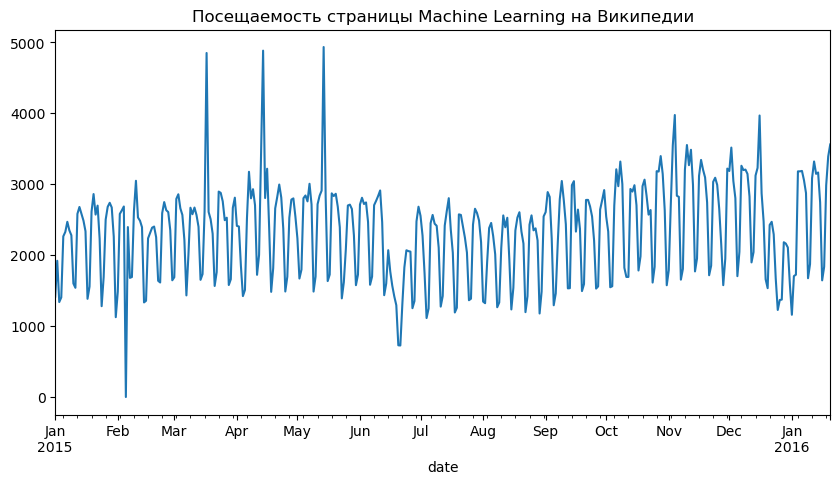

In [10]:
data = pd.read_csv('wiki_machine_learning.csv', sep=' ', quotechar='"', engine='python')

data.columns = data.columns.str.replace('"', '').str.strip()

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


# Функция для вычисления метрик
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape


# Визуализация данных
data['count'].plot(figsize=(10, 5))
plt.title('Посещаемость страницы Machine Learning на Википедии')
plt.show()

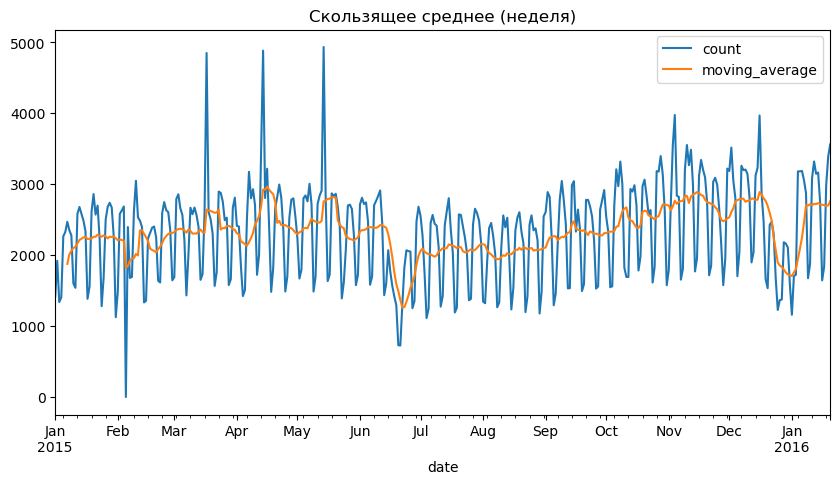

/opt/anaconda3/envs/GMCS/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


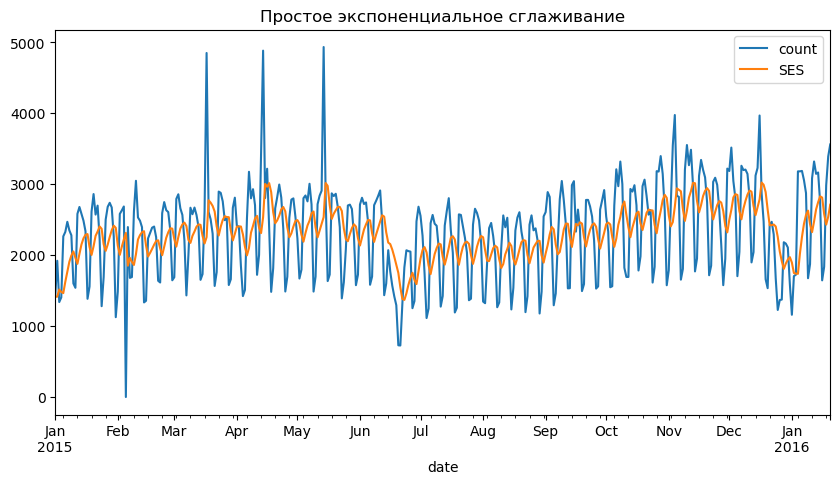

/opt/anaconda3/envs/GMCS/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/GMCS/lib/python3.8/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


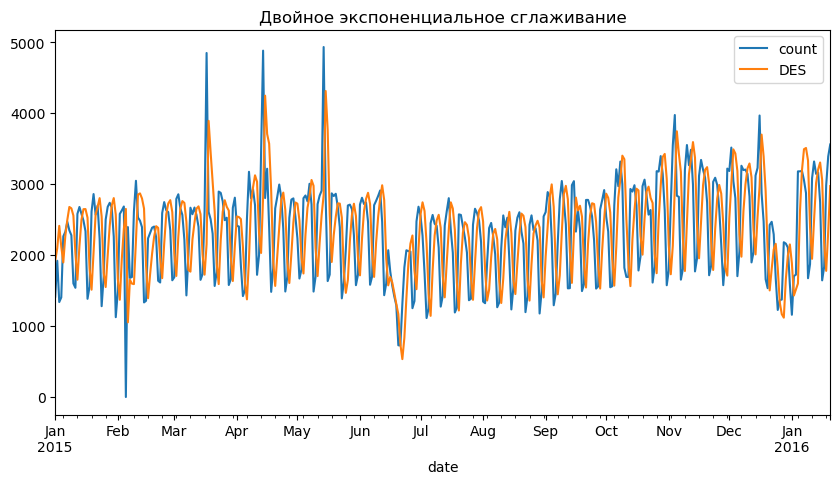

/opt/anaconda3/envs/GMCS/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


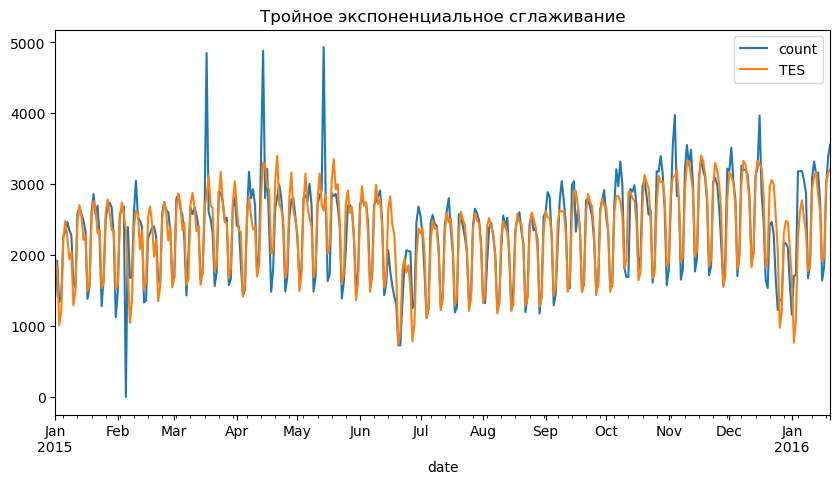

In [8]:
# Скользящее среднее
def moving_average(series, window):
    return series.rolling(window=window).mean()


window = 7  # Неделя
data['moving_average'] = moving_average(data['count'], window)
data[['count', 'moving_average']].plot(figsize=(10, 5))
plt.title('Скользящее среднее (неделя)')
plt.show()

# Простое экспоненциальное сглаживание
alpha = 0.2
model = SimpleExpSmoothing(data['count']).fit(smoothing_level=alpha, optimized=False)
data['SES'] = model.fittedvalues
data[['count', 'SES']].plot(figsize=(10, 5))
plt.title('Простое экспоненциальное сглаживание')
plt.show()

# Двойное экспоненциальное сглаживание
alpha, beta = 0.5, 0.3
model = Holt(data['count']).fit(smoothing_level=alpha, smoothing_trend=beta)
data['DES'] = model.fittedvalues
data[['count', 'DES']].plot(figsize=(10, 5))
plt.title('Двойное экспоненциальное сглаживание')
plt.show()

# Тройное экспоненциальное сглаживание
seasonal_periods = 7  # Неделя
alpha, beta, gamma = 0.2, 0.1, 0.1
model = ExponentialSmoothing(data['count'], seasonal='add', seasonal_periods=seasonal_periods).fit(
    smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
data['TES'] = model.fittedvalues
data[['count', 'TES']].plot(figsize=(10, 5))
plt.title('Тройное экспоненциальное сглаживание')
plt.show()

In [4]:
# Метрики RMSE, MAE, MAPE
metrics = {
    'MAE': [],
    'RMSE': [],
    'MAPE': []
}

# Скользящее среднее
mae, rmse, mape = calculate_metrics(data['count'][window:], data['moving_average'][window:])
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)
metrics['MAPE'].append(mape)

# Простое экспоненциальное сглаживание
mae, rmse, mape = calculate_metrics(data['count'], data['SES'])
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)
metrics['MAPE'].append(mape)

# Двойное экспоненциальное сглаживание
mae, rmse, mape = calculate_metrics(data['count'], data['DES'])
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)
metrics['MAPE'].append(mape)

# Тройное экспоненциальное сглаживание
mae, rmse, mape = calculate_metrics(data['count'], data['TES'])
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)
metrics['MAPE'].append(mape)

# Отображение метрик
metrics_df = pd.DataFrame(metrics, index=['Moving Average', 'SES', 'DES', 'TES'])
print(metrics_df)

                       MAE        RMSE  MAPE
Moving Average  498.250567  600.631296   inf
SES             546.155771  658.644015   inf
DES             631.126794  782.599774   inf
TES             225.707439  354.235437   inf


In [5]:
# Подбор оптимальных параметров на кросс-валидации
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    alpha, beta, gamma = params
    errors = []
    values = series.values
    tscv = TimeSeriesSplit(n_splits=5)

    for train, test in tscv.split(values):
        train_series = values[train]
        model = ExponentialSmoothing(train_series, seasonal='add', seasonal_periods=slen).fit(smoothing_level=alpha,
                                                                                              smoothing_trend=beta,
                                                                                              smoothing_seasonal=gamma)
        predictions = model.forecast(len(test))
        actual = values[test]
        error = loss_function(actual, predictions)
        errors.append(error)

    return np.mean(errors)


data_train = data['count'][:-30]  # Отложим последние 30 точек для теста
initial_params = [0.2, 0.1, 0.1]
opt_params = minimize(timeseriesCVscore, initial_params, args=(data_train,), method='TNC',
                      bounds=((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt_params.x

print(f'Optimal alpha: {alpha_opt}, beta: {beta_opt}, gamma: {gamma_opt}')

Optimal alpha: 0.2, beta: 0.09999999999999998, gamma: 0.09999999999999998


/opt/anaconda3/envs/GMCS/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


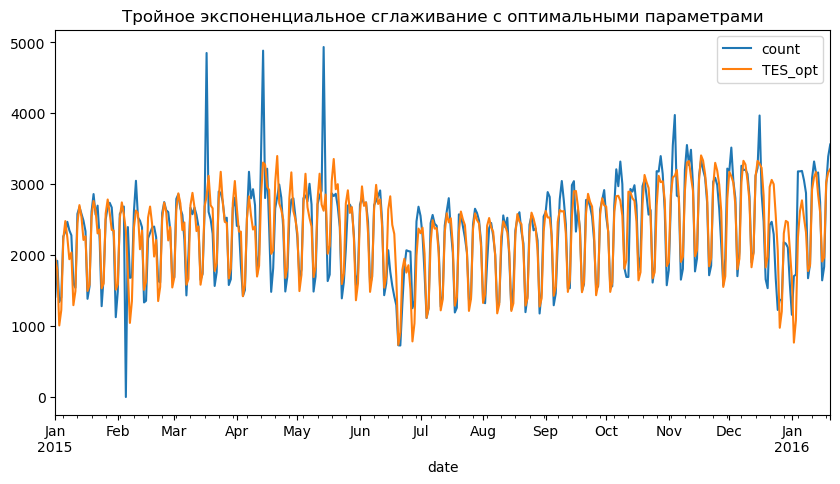

MAE: 225.70668547584947, RMSE: 354.23543653404465, MAPE: inf


In [6]:
# Построение модели с оптимальными параметрами
model = ExponentialSmoothing(data['count'], seasonal='add', seasonal_periods=seasonal_periods).fit(
    smoothing_level=alpha_opt, smoothing_trend=beta_opt, smoothing_seasonal=gamma_opt)
data['TES_opt'] = model.fittedvalues
data[['count', 'TES_opt']].plot(figsize=(10, 5))
plt.title('Тройное экспоненциальное сглаживание с оптимальными параметрами')
plt.show()

# Метрики для модели с оптимальными параметрами
mae, rmse, mape = calculate_metrics(data['count'], data['TES_opt'])
print(f'MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')